1. Construa uma função (codificador) que para cada bloco de 8×8 da imagem original efetue a DCT bidimensional
e construa outra função (descodificador) que faça a DCT inversa. Ver funções: cv2.dct() e cv2.idct())
Visualize a imagem depois da DCT e verifique que a DCT inversa resulta na imagem original.

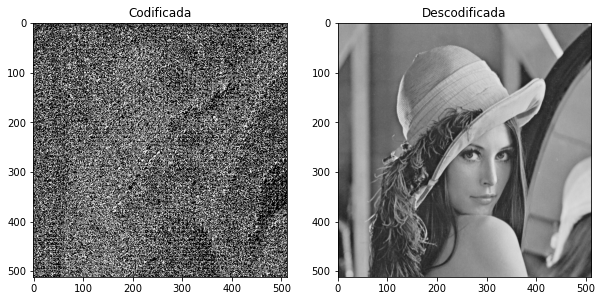

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def codificador(image):
    
    # Verifica as dimensões da imagem
    linhas, colunas = image.shape[:2]

    # Cria uma cópia da imagem original para a DCT
    encoded = np.array(image) 
    
    for linha in range(0,linhas,8):          
        for coluna in range(0,colunas,8):
            
            # Seleciona um bloco de 8x8 pixels
            bloco = image[linha:linha+8, coluna:coluna+8]
            
            # Aplica a DCT bidimensional no bloco
            bloco_dct = cv2.dct(bloco) 
            
            # Armazena o bloco codificado
            encoded[linha:linha+8, coluna:coluna+8]  = bloco_dct 
    
    # Retorna a imagem codificada
    return encoded

def descodificador(encoded):
    
    # Verifica as dimensões da imagem
    linhas, colunas = encoded.shape[:2]

    # Cria uma cópia da imagem codificada para a DCT inversa
    decoded = np.array(encoded)

    # Loop sobre os blocos de 8x8 pixels
    for linha in range(0, linhas, 8):
        for coluna in range(0, colunas, 8):
            
            # Seleciona um bloco de 8x8 pixels
            bloco = encoded[linha:linha+8, coluna:coluna+8]

            # Aplica a DCT inversa no bloco
            bloco_dct = cv2.idct(bloco)

            # Armazena o bloco decodificado
            decoded[linha:linha+8, coluna:coluna+8] = bloco_dct

    # Retorna a imagem decodificada
    return decoded

# Exemplo de uso
# Carrega a imagem
image = cv2.imread("LenaGray.tif", cv2.IMREAD_GRAYSCALE)
image_float = np.array(image, dtype=np.float64) 

# Codifica a imagem
encoded = codificador(image_float)


# Decodifica a imagem
decoded = descodificador(encoded)

#Passamos as duas para uint8
encoded = np.uint8(encoded)
decoded = np.uint8(decoded)

cv2.imwrite('dct.tif', encoded) 
cv2.imwrite('idct.tif', decoded)

# Exibe a imagem original e a imagem decodificada lado a lado
cv2.imshow("Codificada vs Descodificada", np.hstack((encoded, decoded)))

cv2.waitKey(0)
cv2.destroyAllWindows()

#Convertemos para ser possivel usar matplot
encoded_plt = cv2.cvtColor(encoded, cv2.COLOR_BGR2RGB)
decoded_plt = cv2.cvtColor(decoded, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

axes[0].imshow(encoded_plt)
axes[1].imshow(decoded_plt)

axes[0].set_title('Codificada')
axes[1].set_title('Descodificada')

plt.show()


A matriz de quantificação foi disponibilizada juntamente com o enunciado do trabalho, e está apresentada abaixo:

In [30]:
K1 = np.zeros((8, 8)) 
K1[0] = [ 16,  11,  10,  16,  24,  40,  51,  61] 
K1[1] = [ 12,  12,  14,  19,  26,  58,  60,  55] 
K1[2] = [ 14,  13,  16,  24,  40,  57,  69,  56] 
K1[3] = [ 14,  17,  22,  29,  51,  87,  80,  62] 
K1[4] = [ 18,  22,  37,  56,  68, 109, 103,  77] 
K1[5] = [ 24,  35,  55,  64,  81, 104, 113,  92] 
K1[6] = [ 49,  64,  78,  87, 103, 121, 120, 101] 
K1[7] = [ 72,  92,  95,  98, 112, 100, 103,  99]

In [31]:
def quality_factor(q):
        if(q <= 50):
            factor = 50.0 / q
        else:
            factor = 2.0 - (q * 2.0)/100.0
        return factor 

In [32]:
def codificador(image, matriz, fator):
    
    # Verifica as dimensões da imagem
    linhas, colunas = image.shape[:2]
    
    # Cria uma cópia da imagem original
    encoded = np.array(image)
    
    #Calculamos o fator de compressao multiplicando a matriz K1 pelo
    #fator recebido
    fator_compressao = np.multiply(matriz, quality_factor(fator))
    
    
    for linha in np.arange(0,linhas,8):          
        for coluna in np.arange(0,colunas,8):
            
            # Seleciona um bloco de 8x8 pixels
            bloco = image[linha:linha+8, coluna:coluna+8]
            
            # Aplica a DCT bidimensional no bloco
            bloco_dct = cv2.dct(bloco) 
            
            # Quantificamos
            quantificacao = np.round(np.divide(bloco_dct, fator_compressao))
            
            # Armazena o bloco codificado
            encoded[linha:linha+8, coluna:coluna+8]  = quantificacao 
    
    # Retorna a imagem codificada
    return encoded

def descodificador(encoded, matriz, fator):
    
    # Verifica as dimensões da imagem
    linhas, colunas = encoded.shape[:2]

    # Cria uma cópia da imagem codificada para a DCT inversa
    decoded = np.array(encoded)
    
    #Calculamos o fator de compressao multiplicando a matriz K1 pelo
    #fator recebido
    fator_compressao = np.multiply(matriz, quality_factor(fator))

    # Loop sobre os blocos de 8x8 pixels
    for linha in np.arange(0, linhas, 8):
        for coluna in np.arange(0, colunas, 8):
            
            # Seleciona um bloco de 8x8 pixels
            bloco = encoded[linha:linha+8, coluna:coluna+8]
            bloco_dct = np.round(np.multiply(bloco, fator_compressao))
            
            # Aplica a DCT inversa no bloco
            inversa = cv2.idct(bloco_dct)
            
            # Armazena o bloco decodificado
            decoded[linha:linha+8, coluna:coluna+8] = inversa

    # Retorna a imagem decodificada
    return decoded

In [33]:
def SNR(original,descodificada):       
    
    imageO = original.ravel()     
    noise = original.astype(float) - descodificada.astype(float)     
    imageA = noise.ravel()      
    
    pOriginal = np.sum(imageO**2.)     
    pdescodificada = np.sum(imageA**2.)  
    
    SNR = 10*np.log10(pOriginal/pdescodificada)  
    
    return round(SNR,2)

--------------- Exercicio 2 -------------------

Fator de qualidade = 25

SNR: 28.06


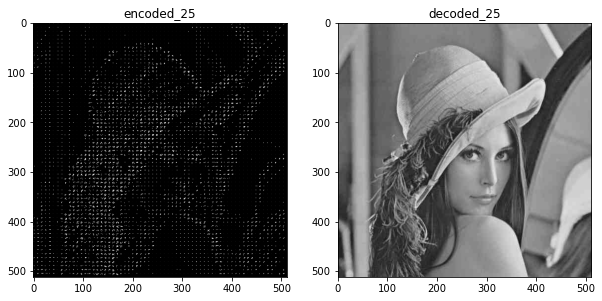


Fator de qualidade = 50

SNR: 30.17


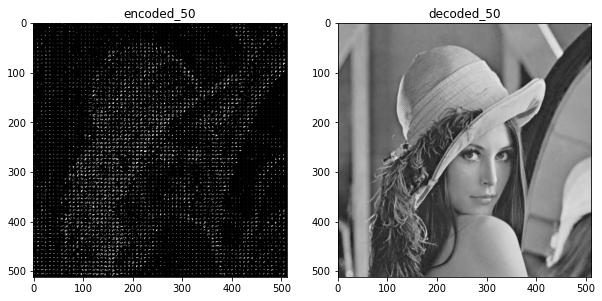


Fator de qualidade = 75

SNR: 32.24


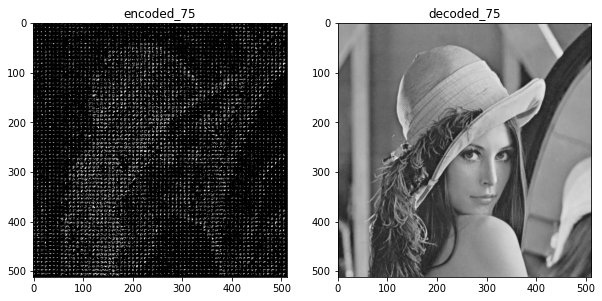

In [34]:
# Exemplo de uso
# Carrega a imagem
image = cv2.imread("LenaGray.tif", cv2.IMREAD_GRAYSCALE)
image_float = np.array(image, dtype=np.float64)

print("--------------- Exercicio 2 -------------------") 
print() 
print("Fator de qualidade = 25") 
print()

fator_qualidade = 25     

encoded_25 = codificador(image_float, K1, fator_qualidade) 
decoded_25 = descodificador(encoded_25, K1, fator_qualidade)

print("SNR: " + str(SNR(image, decoded_25)))

cv2.imwrite('dct_25.tif', encoded_25) 
cv2.imwrite('idct_25.tif', decoded_25)

encoded_25 = np.uint8(encoded_25)
decoded_25 = np.uint8(decoded_25)

cv2.imshow('encoded_25', encoded_25)
cv2.namedWindow('encoded_25', cv2.WINDOW_AUTOSIZE)
cv2.imshow('decoded_25 ', decoded_25)
cv2.namedWindow('decoded_25 ', cv2.WINDOW_AUTOSIZE)


cv2.waitKey(0)
cv2.destroyAllWindows()

#Convertemos para ser possivel usar matplot
encoded_25_plt = cv2.cvtColor(encoded_25, cv2.COLOR_BGR2RGB)
decoded_25_plt = cv2.cvtColor(decoded_25, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

axes[0].imshow(encoded_25_plt)
axes[1].imshow(decoded_25_plt)

axes[0].set_title('encoded_25')
axes[1].set_title('decoded_25')

plt.show()

print() 
print("Fator de qualidade = 50") 
print()

fator_qualidade = 50     

encoded_50 = codificador(image_float, K1, fator_qualidade) 
decoded_50 = descodificador(encoded_50, K1, fator_qualidade)

print("SNR: " + str(SNR(image, decoded_50)))

cv2.imwrite('dct_50.tif', encoded_50) 
cv2.imwrite('idct_50.tif', decoded_50)

encoded_50 = np.uint8(encoded_50)
decoded_50 = np.uint8(decoded_50)

cv2.imshow('encoded_50', encoded_50)
cv2.namedWindow('encoded_50', cv2.WINDOW_AUTOSIZE)
cv2.imshow('decoded_50 ', decoded_50)
cv2.namedWindow('decoded_50 ', cv2.WINDOW_AUTOSIZE)


cv2.waitKey(0)
cv2.destroyAllWindows()

#Convertemos para ser possivel usar matplot
encoded_50_plt = cv2.cvtColor(encoded_50, cv2.COLOR_BGR2RGB)
decoded_50_plt = cv2.cvtColor(decoded_50, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

axes[0].imshow(encoded_50_plt)
axes[1].imshow(decoded_50_plt)

axes[0].set_title('encoded_50')
axes[1].set_title('decoded_50')

plt.show()

print() 
print("Fator de qualidade = 75") 
print()

fator_qualidade = 75    

encoded_75 = codificador(image_float, K1, fator_qualidade) 
decoded_75 = descodificador(encoded_75, K1, fator_qualidade)

print("SNR: " + str(SNR(image, decoded_75)))

cv2.imwrite('dct_75.tif', encoded_75) 
cv2.imwrite('idct_75.tif', decoded_75)

encoded_75 = np.uint8(encoded_75)
decoded_75 = np.uint8(decoded_75)

cv2.imshow('encoded_75', encoded_75)
cv2.namedWindow('encoded_75', cv2.WINDOW_AUTOSIZE)
cv2.imshow('decoded_75 ', decoded_75)
cv2.namedWindow('decoded_75 ', cv2.WINDOW_AUTOSIZE)


cv2.waitKey(0)
cv2.destroyAllWindows()

#Convertemos para ser possivel usar matplot
encoded_75_plt = cv2.cvtColor(encoded_75, cv2.COLOR_BGR2RGB)
decoded_75_plt = cv2.cvtColor(decoded_75, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

axes[0].imshow(encoded_75_plt)
axes[1].imshow(decoded_75_plt)

axes[0].set_title('encoded_75')
axes[1].set_title('decoded_75')

plt.show()



Ao observar os resultados obtidos, chegamos à conclusão que a relação sinal ruido é proporcional ao fator de qualidade, ou seja, quanto maior a qualidade da imagem maior é o seu SNR.